In [51]:
import pandas as pd
import numpy as np
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib
import json
import matplotlib.pyplot as plt
import os
import seaborn as sns
import plotly.express as px




sns.set_context("talk", font_scale=1)
sns.set_style("darkgrid")
sns.set_palette('tab10')
sns.set_color_codes()

In [10]:
music_df = pd.read_json('StreamingHistory0.json')
df2 = pd.read_json('StreamingHistory1.json')
df3 = pd.read_json('StreamingHistory2.json')
df4 = pd.read_json('StreamingHistory3.json')
df5 = pd.read_json('StreamingHistory4.json')
music_df = pd.concat([music_df, df2, df3, df4, df5])

In [11]:
music_df.head(10)
#df.tail(10)
#df.info()

,endTime,artistName,trackName,msPlayed
0,2022-09-22 16:28,Death Cab for Cutie,Transatlanticism,244250
1,2022-11-02 00:02,Alan Walker,Faded,212626
2,2022-11-02 00:03,Alan Walker,Faded,52928
3,2022-11-02 00:14,The Floating Mind,Brown Noise (200 Hz),12695
4,2022-11-02 00:14,Justin Warnick,Stranger,157499
5,2022-11-02 00:16,Weekend,Coma Summer,11754
6,2022-11-02 00:16,Two Feet,Your Mother Was Cheaper,3249
7,2022-11-02 00:16,King Krule,363N63,121292
8,2022-11-02 00:16,John Mayer,Waiting On the World to Change,2474
9,2022-11-02 00:20,Jeff Rosenstock,We Begged 2 Explode,224149


In [14]:
music_df['endTime']=pd.to_datetime(music_df['endTime'])
music_df['minPlayed']=(music_df['msPlayed']/1000/60)
music_df.drop('msPlayed', axis=1, inplace=True)

In [15]:
music_df.head()

,endTime,artistName,trackName,minPlayed
0,2022-09-22 16:28:00,Death Cab for Cutie,Transatlanticism,4.070833
1,2022-11-02 00:02:00,Alan Walker,Faded,3.543767
2,2022-11-02 00:03:00,Alan Walker,Faded,0.882133
3,2022-11-02 00:14:00,The Floating Mind,Brown Noise (200 Hz),0.211583
4,2022-11-02 00:14:00,Justin Warnick,Stranger,2.624983


In [16]:
music_df.tail()

,endTime,artistName,trackName,minPlayed
6272,2023-11-02 21:38:00,The War On Drugs,Nothing to Find,3.724133
6273,2023-11-02 22:16:00,James Blake,CMYK,3.654583
6274,2023-11-02 22:17:00,Burial,Kindred,0.125867
6275,2023-11-02 22:22:00,Burial,Ashtray wasp,5.185067
6276,2023-11-02 23:04:00,Burial,Near Dark,0.009233


In [17]:
music_df['dayOfWeek']=music_df['endTime'].dt.day_name()
music_df['dayOfMonth']=music_df['endTime'].dt.day
music_df['timeOfDay']=music_df['endTime'].dt.hour
music_df['date']=music_df['endTime'].dt.date

In [18]:
music_df.head()

,endTime,artistName,trackName,minPlayed,dayOfWeek,dayOfMonth,timeOfDay,date
0,2022-09-22 16:28:00,Death Cab for Cutie,Transatlanticism,4.070833,Thursday,22,16,2022-09-22
1,2022-11-02 00:02:00,Alan Walker,Faded,3.543767,Wednesday,2,0,2022-11-02
2,2022-11-02 00:03:00,Alan Walker,Faded,0.882133,Wednesday,2,0,2022-11-02
3,2022-11-02 00:14:00,The Floating Mind,Brown Noise (200 Hz),0.211583,Wednesday,2,0,2022-11-02
4,2022-11-02 00:14:00,Justin Warnick,Stranger,2.624983,Wednesday,2,0,2022-11-02


In [36]:
print("I listened to {} tracks, {:.3f} per day in the last year (crazy!)".format( len(music_df), len(music_df)/365))

I listened to 46277 tracks, 126.786 per day in the last year (crazy!)


In [20]:
print("This amounts to about {} hours total, and {:.3f} hours per day.".format(music_df.minPlayed.sum()/60, music_df.minPlayed.sum()/365/60))

This amounts to about 2228.3570124999997 hours total, and 6.105 hours per day.


In [21]:
print("which then equates to about {:.3f} minutes per song.".format(music_df.minPlayed.sum()/len(music_df)))

which then equates to about 2.889 minutes per song.


In [55]:
artist_track_count = music_df.groupby('artistName')['trackName'].count().reset_index()
artist_track_count.columns = ['artist', 'play counts']

artist_track_count = artist_track_count.sort_values('play counts', ascending = False)
artist_track_count.head()
artist_track_short = artist_track_count[:10]

In [72]:
fig = px.bar(artist_track_short, x='play counts', y='artist', orientation='h',
             labels={'play counts': 'play counts', 'artist': 'artist'},
             title='Track Count for Each Artist')
fig.update_traces(text=artist_track_short.apply(lambda x: f"{x['play counts']}", axis=1),
                  textposition='inside')

fig.show()

In [74]:
track_counts = music_df.groupby('trackName').size().reset_index(name = 'Listen Count')
track_counts = track_counts.sort_values('Listen Count', ascending=False)
track_counts
track_counts.head(20)

,trackName,Listen Count
2942,Haldern,281
783,Basketball Shoes,208
1523,Concorde,180
7703,Track X,165
8767,i tried,162
6219,Self Control,159
7382,The Place Where He Inserted the Blade,149
4537,Making The Band (Danity Kane),132
8926,skin in the game,129
8809,kisses,124


In [71]:
track_counts_short = track_counts[:10]
fig = px.bar(track_counts_short, x='Listen Count', y='trackName', orientation='h',
             labels={'Listen Count': 'Listen Count', 'trackName': 'trackName'},
             title='Listen Count for each Song')
fig.update_traces(text=track_counts_short['Listen Count'], textposition='outside')
fig.update_traces(text=track_counts_short.apply(lambda x: f"{x['Listen Count']}", axis=1),
                  textposition='inside')

fig.show()

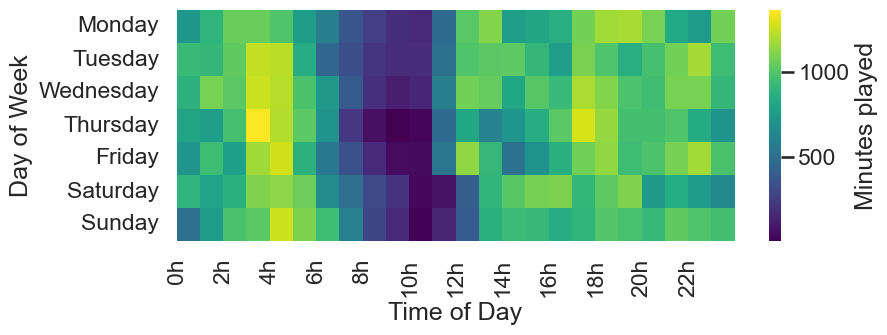

In [28]:
timevsweek = music_df.pivot_table(columns='timeOfDay', index='dayOfWeek', 
                                    values='minPlayed', aggfunc=np.sum).fillna(0)
#week days were scrambled
timevsweek = timevsweek.iloc[[1,5,6,4,0,2,3],:]
fig = plt.figure(figsize=(9,3))
ax = sns.heatmap(timevsweek, cmap='viridis',
                 cbar_kws=dict(label='Minutes played'))

xticks = np.arange(24)
xticklabels = [str(i) + 'h' for i in xticks]
ax.set_xticks(xticks[::2])
ax.set_xticklabels(xticklabels[::2])
ax.tick_params('x',rotation=90)

ax.set_xlabel('Time of Day')
ax.set_ylabel('Day of Week')
fig.patch.set_facecolor('white')
plt.show()

In [32]:
weekend_music = music_df.loc[music_df['dayOfWeek'].isin(['Friday','Saturday','Sunday'])]
weekend_music.head()

,endTime,artistName,trackName,minPlayed,dayOfWeek,dayOfMonth,timeOfDay,date
270,2022-11-04 00:14:00,The War On Drugs,An Ocean In Between The Waves,7.195767,Friday,4,0,2022-11-04
271,2022-11-04 00:57:00,The War On Drugs,Disappearing,6.860433,Friday,4,0,2022-11-04
272,2022-11-04 01:03:00,The War On Drugs,Eyes To The Wind,5.932667,Friday,4,1,2022-11-04
273,2022-11-04 01:17:00,The War On Drugs,The Haunting Idle,3.132217,Friday,4,1,2022-11-04
274,2022-11-04 01:22:00,The War On Drugs,Burning,2.375650,Friday,4,1,2022-11-04
